#Atividade 02 de Resistência dos Materiais - Questão 01

Grupo:
1. Júlia Zoffoli Caçador.  202365520B
2. Robert Gonçalves Vieira de Souza. 202365505B
3. Rubia Danielle Viol. 202365515B

Professor Artur Hallack

**OBS:** O pdf para o relatório e a validação dos cálculos realizados pela rotina computacional desenvolvida se encontra em anexo.

**OBS²:** A questão 02 está em outro arquivo colab, que foi enviado juntamente no classroom.

## Questão 01

Com base no Problema 02 da Atividade 01, desenvolva uma rotina computacional para cálculo dos esforços internos isostáticas (equações M(x) e V(x)) e para representação dos respectivos diagramas em vigas isostáticas.

### Código da Atividade 01 - Questão 02:

In [ ]:
from sympy import symbols, integrate, Eq, solve, Heaviside, lambdify
import matplotlib.pyplot as plt
import numpy as np
import math

def separaComponentes (F, theta):
  theta = math.radians(theta)
  x = F * math.cos(theta)
  y = F * math.sin(theta)

  return x,y

enumCarregamento = {
    1: "Retangular",
    2: "Triangular",
    3: "Trapézoidal"
}

enumApoio = {
    1: "Apoio de 1° gênero",
    2: "Apoio de 2° gênero",
    3: "Apoio de 3° gênero"
}

enumEstabilidade = {
    1: "Hipoestática",
    2: "Isostática",
    3: "Hiperestática"
}

NUM_EQUACOES = 3

# Classe que armazena informações sobre carregamentos pontuais e
# utiliza a função implementada na 1ª questão para decompor as componentes x e y de forças inclinadas
class CarregamentoPontual:
    def __init__(self, intensidade, posicao, angulacao):
      self.fy, self.fx = separaComponentes(intensidade, angulacao)
      self.posicao = posicao

class CarregamentoDistribuido:
    #funcao que calcula os coeficientes a e b para encontrar a função w(x) dado os pontos min e max dos carregamentos
    def funcao_w (self):
      # Se w inicial = w final, então é uma carga constante
      if self.w[0] == self.w[1]:
        funcao_w = self.w[0]  # Retorna diretamente o valor constante
      else:
        # Caso não constante - mantém a lógica atual
        a = (self.w[1] - self.w[0])/(self.p[1] - self.p[0])
        b = self.w[0] - a*self.p[0]
        funcao_w = a*self.x + b

      return funcao_w

    def __init__(self, tipo, w0, w1, p0, pf): #construtor
      self.tipo = enumCarregamento[tipo]
      self.w = [w0, w1] # w inicial e w final
      self.p = [p0, pf] # posição inicial e final

      self.x = symbols('x')
      self.resultante = integrate(self.funcao_w(), (self.x, self.p[0],self.p[1])) # calculo da integral de w(x) definida no intervalo de p0 a pf para encontrar a resultante
      self.centroide = integrate(self.funcao_w()*self.x, (self.x, self.p[0],self.p[1]))/self.resultante # calculo do centroide (posição em que a força resultante será aplicada)

class Apoio:
    def __init__(self, letra, tipo, posicao = 0): # construtor do apoio com todos os seus atributos
      self.letra = letra
      self.tipo = enumApoio[tipo]
      self.posicao = posicao

      self.fx = symbols(f'{letra}_x')
      self.fy = symbols(f'{letra}_y')

      if(self.tipo == enumApoio[1]):
        self.fx = 0

def gerar_numIncognitas(lista_apoios):
  numIncognitas = 0
  for i in range (len(lista_apoios)):
    if lista_apoios[i].tipo == enumApoio[1]: # apoio de 1º gênero: +1 incógnita
      numIncognitas += 1
    elif lista_apoios[i].tipo == enumApoio[2]: # apoio de 2º gênero: +2 incógnita
      numIncognitas += 2
    elif lista_apoios[i].tipo == enumApoio[3]: # apoio de 3º gênero: +3 incógnita
      numIncognitas += 3
  return numIncognitas

def get_estabilidade(lista_apoios): # cálculo da estabilidade da viga com base no número de incógnitas e de equações
  global NUM_EQUACOES
  numIncognitas = gerar_numIncognitas(lista_apoios)
  if numIncognitas > NUM_EQUACOES:
    return enumEstabilidade[3]
  elif numIncognitas == NUM_EQUACOES:
    return enumEstabilidade[2]
  else:
    return enumEstabilidade[1]

def calcula_reacoes(lista_carregamentos, lista_apoios):
  vars_fx = []
  vars_fy = []
  M = 0
  soma = 0

  for i in range(len(lista_apoios)):
    if(lista_apoios[i].tipo != enumApoio[1]): #2º e 3º gênero: acrescenta somatório de fx
      vars_fx.append(lista_apoios[i].fx)

    vars_fy.append(lista_apoios[i].fy) # somatório em fy

    if(lista_apoios[i].tipo == enumApoio[3]):
      M = symbols('M')
      soma += M

    if lista_apoios[i].tipo != enumApoio[3] and i > 0: # momento para apoios
      soma += lista_apoios[i].fy*(lista_apoios[i].posicao - lista_apoios[0].posicao)

  for carregamento in lista_carregamentos: # momento para carregamento
    soma -= carregamento.fy*carregamento.posicao

  fx = Eq(sum(vars_fx) - sum(lista_carregamentos[i].fx for i in range(len(lista_carregamentos))), 0) # soma de todos fx - soma dos carregamentos em fx
  fy = Eq(sum(vars_fy) - sum(lista_carregamentos[i].fy for i in range(len(lista_carregamentos))), 0) # soma de todos fy - soma dos carregamentos em fy
  momento = Eq(soma, 0) # soma do momento = zero

  solucao = solve((fx, fy, momento), *vars_fx, *vars_fy, M) #solução

  return solucao

def plotar_viga(lista_carregamentos_distribuidos, lista_carregamentos_pontuais, lista_apoios, solucao):
  plt.figure(figsize=(12, 6))

  # Plota viga
  comprimento = lista_apoios[-1].posicao  # Pega a posição do último apoio
  plt.plot([0, comprimento], [0, 0], 'k-', linewidth=2)

  # Plota apoios
  for apoio in lista_apoios:
    if apoio.tipo == enumApoio[1]:  # Apoio de 1º gênero
      plt.plot([apoio.posicao], [0], 'k^', markersize=10, label=f'Apoio {apoio.letra} de 1° gênero')
    elif apoio.tipo == enumApoio[2]:  # Apoio de 2º gênero
      plt.plot([apoio.posicao], [0], 'ko', markersize=10, label=f'Apoio {apoio.letra} de 2° gênero')
    elif apoio.tipo == enumApoio[3]:  # Apoio de 3º gênero
      plt.plot([apoio.posicao], [0], 'ks', markersize=10, label=f'Apoio {apoio.letra} de 3° gênero')

  # Plota cargas
  for carga in lista_carregamentos_pontuais:
    plt.arrow(carga.posicao, 2, 0, -1.5, head_width=0.1, head_length=0.2, fc='blue', ec='blue', label='Carga Pontual')

  for carga in lista_carregamentos_distribuidos:
    x = np.linspace(carga.p[0], carga.p[1], 100)
    if carga.tipo == "Retangular":
      y = np.ones_like(x) * carga.w[0]
      label = 'Carga Distribuída Retangular'
    elif carga.tipo == "Triangular":
      y = np.linspace(carga.w[0], carga.w[1], 100)
      label = 'Carga Distribuída Triangular'
    else:
      y = np.linspace(carga.w[0], carga.w[1], 100)
      label = 'Carga Distribuída Trapézoidal'
    plt.fill_between(x, 0, -y / 1000, alpha=0.3, label=label)

  # Plota reações nos apoios
  escala = 1  # Fator de escala para as reações
  for apoio in lista_apoios:
    plt.arrow(apoio.posicao, 0, 0, 2, head_width=0.1, head_length=0.2, fc='red', ec='red')  # Seta vertical

    if apoio.tipo != enumApoio[1]:
      plt.arrow(apoio.posicao - 2.5, 0, 2, 0, head_width=0.1, head_length=0.2, fc='red', ec='red')  # Seta horizontal

  plt.grid(True)
  plt.axis('equal')
  plt.title('Análise da Viga')
  plt.xlabel('Posição (m)')
  plt.ylabel('Carga (N/m)')
  plt.legend()
  plt.show()

TIPOS DE CARREGAMENTO:
Insira quantos carregamentos pontuais existem na sua viga: 1
Insira quantos carregamentos distribuídos existem na sua viga: 1

CARREGAMENTO PONTUAL:
Insira a intensidade da 1° carga pontual: 30
Insira a posição da 1° carga pontual: 4
Insira a angulação em relação ao eixo y da 1° carga pontual: 0

CARREGAMENTO DISTRIBUIDO:

TIPOS DE CARREGAMENTOS DISTRIBUIDOS:
1. Retangular
2. Triangular
3. Trapézoidal

Insira o número correspondente ao tipo do 1° carregamento distribuido: 2
Insira w0 do 1° carregamento distribuido: 135
Insira w1 do 1° carregamento distribuido: 0
Insira a posição inicial do 1° carregamento distribuido: 1
Insira a posição final do 1° carregamento distribuido: 3

APOIOS:
Insira quantos apoios existem na sua viga: 2

TIPOS DE APOIO:
1. Apoio de 1° gênero
2. Apoio de 2° gênero
3. Apoio de 3° gênero

Insira o número correspondente ao tipo do Apoio A: 2
Insira a posição do Apoio A: 0

Insira o número correspondente ao tipo do Apoio B: 1
Insira a posição

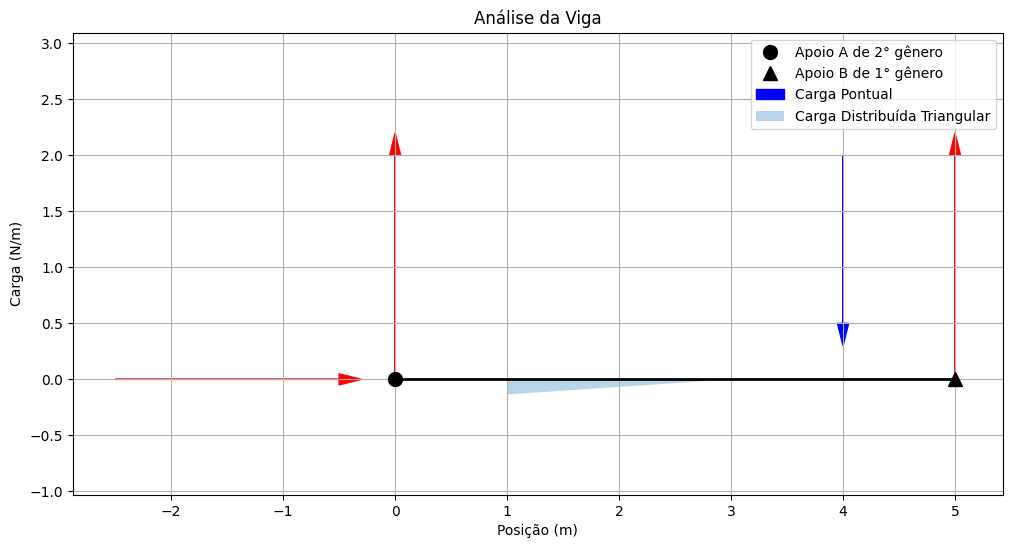

In [ ]:
import string
letras = string.ascii_uppercase[:100]

#instruções para o usuário inserir1 a configuração de viga que desejar
print ("TIPOS DE CARREGAMENTO:")
carregamentos_pontuais = int(input("Insira quantos carregamentos pontuais existem na sua viga: "))
carregamentos_distribuidos = int(input("Insira quantos carregamentos distribuídos existem na sua viga: "))

lista_carregamentos_pontuais = []
lista_carregamentos_distribuidos = []

if(carregamentos_pontuais > 0):
  print("\nCARREGAMENTO PONTUAL:")

  for i in range (carregamentos_pontuais):
    intensidade = float(input(f"Insira a intensidade da {i+1}° carga pontual: "))
    posicao = float(input(f"Insira a posição da {i+1}° carga pontual: "))
    angulacao = float(input(f"Insira a angulação em relação ao eixo y da {i+1}° carga pontual: "))

    lista_carregamentos_pontuais.append(CarregamentoPontual(intensidade, posicao, angulacao))

print ("\nCARREGAMENTO DISTRIBUIDO:")
print ("\nTIPOS DE CARREGAMENTOS DISTRIBUIDOS:")
print ("1. Retangular")
print ("2. Triangular")
print ("3. Trapézoidal")

w0, w1, p0, p1 = 0, 0, 0, 0
for i in range (carregamentos_distribuidos):
  tipo = int(input(f"\nInsira o número correspondente ao tipo do {i+1}° carregamento distribuido: "))

  if(tipo == 1):
    w0 = float(input(f"Insira w do {i+1}° carregamento distribuido: "))
    w1 = w0
  else:
    w0 = float(input(f"Insira w{i} do {i+1}° carregamento distribuido: "))
    w1 = float(input(f"Insira w{i+1} do {i+1}° carregamento distribuido: "))

  p0 = float(input(f"Insira a posição inicial do {i+1}° carregamento distribuido: "))
  pf = float(input(f"Insira a posição final do {i+1}° carregamento distribuido: "))

  lista_carregamentos_distribuidos.append(CarregamentoDistribuido(tipo, w0, w1, p0, pf))

lista_carregamentos = [CarregamentoPontual(lista_carregamentos_distribuidos[i].resultante, lista_carregamentos_distribuidos[i].centroide, 0) for i in range (carregamentos_distribuidos)] + lista_carregamentos_pontuais

print ("\nAPOIOS:")
num_apoios = int(input("Insira quantos apoios existem na sua viga: "))
lista_apoios = []

print ("\nTIPOS DE APOIO:")
print ("1. Apoio de 1° gênero")
print ("2. Apoio de 2° gênero")
print ("3. Apoio de 3° gênero")

for i in range (num_apoios):
  tipo_apoio = int(input(f"\nInsira o número correspondente ao tipo do Apoio {letras[i]}: "))
  posicao = float(input(f"Insira a posição do Apoio {letras[i]}: "))

  lista_apoios.append(Apoio(letras[i], tipo_apoio, posicao))

if gerar_numIncognitas(lista_apoios) != NUM_EQUACOES:
  print(f"ERRO: Vigas Hiperestáticas e/ou Hipoestáticas não podem ser calculadas. A sua é {get_estabilidade(lista_apoios)}")
  exit(1)
else:
  solucao = calcula_reacoes(lista_carregamentos, lista_apoios) #calculo das reações de apoio

  #impressão dos resultados
  print("\n\n====================================")
  print(f"RESULTADO:")
  print("====================================")

  for i in range(len(lista_carregamentos)):
      print(f"\nCarregamento {i+1}:")
      print(f"Fx: {lista_carregamentos[i].fx:.2f}")
      print(f"Fy: {lista_carregamentos[i].fy:.2f}")
      print(f"Posição: {lista_carregamentos[i].posicao:.2f}")

  print("\n====================================")
  print("\nReações nos apoios:")
  for dado in solucao:
      print(f"{dado}: {solucao[dado]:.2f}")


  print("\n====================================")

plotar_viga(lista_carregamentos_distribuidos, lista_carregamentos_pontuais, lista_apoios, solucao)

### Código da atividade atual:

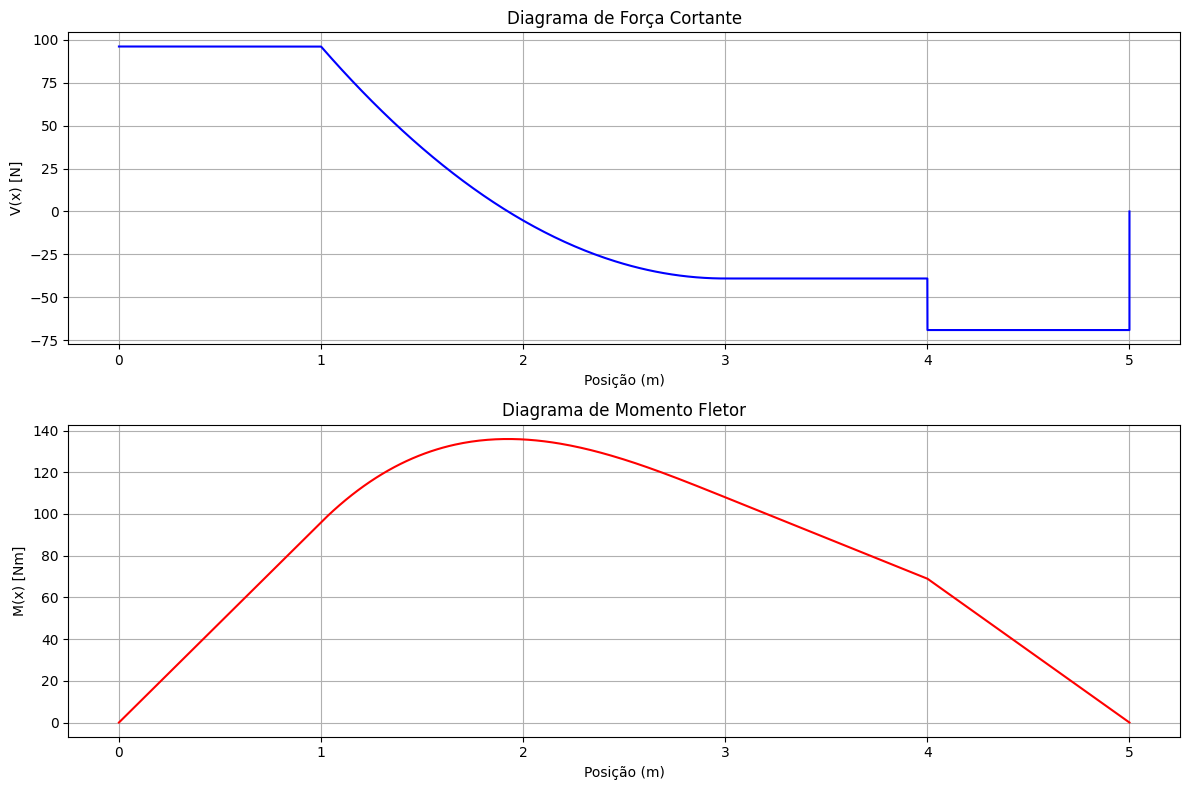

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def heaviside(x):
    return 1.0 if x >= 0 else 0.0

def calcular_esforcos_internos(x, lista_carregamentos_pontuais, lista_carregamentos_distribuidos, lista_apoios, solucao):
    V = 0
    M = 0

    for apoio in lista_apoios:
        if apoio.fy in solucao:
            reacao = solucao[apoio.fy]
            pos = apoio.posicao
            V += reacao * heaviside(x - pos)
            M += reacao * (x - pos) * heaviside(x - pos)

    for carga in lista_carregamentos_pontuais:
        Fy = carga.fy
        pos = carga.posicao
        V -= Fy * heaviside(x - pos)
        M -= Fy * (x - pos) * heaviside(x - pos)

    for carga_dist in lista_carregamentos_distribuidos:
        a = carga_dist.p[0]
        b = carga_dist.p[1]

        if carga_dist.tipo == "Retangular":
            w = carga_dist.w[0]

            if x > a:
                if x <= b:
                    V -= w * (x - a)
                    M -= w * (x - a)**2 / 2
                else:
                    V -= w * (b - a)
                    M -= w * (b - a)**2 / 2 + w * (b - a) * (x - b)

        elif carga_dist.tipo in ["Triangular", "Trapézoidal"]:
            w1 = carga_dist.w[0]
            w2 = carga_dist.w[1]

            if x > a:
                if x <= b:
                    alpha = (x - a) / (b - a)
                    w_x = w1 + (w2 - w1) * alpha
                    V -= (w1 + w_x) * (x - a) / 2
                    M -= (2 * w1 + w_x) * (x - a)**2 / 6
                else:
                    R = (w1 + w2) * (b - a) / 2
                    xc = (b - a) * (2 * w1 + w2) / (3 * (w1 + w2))
                    M_b = (w1 + w2) * (b - a)**2 / 6
                    V -= R
                    M -= M_b + R * (x - (a + xc))

    return V, M

def plotar_diagramas(lista_carregamentos_pontuais, lista_carregamentos_distribuidos, lista_apoios, solucao, comprimento):
    pontos_transicao = set()
    for carga in lista_carregamentos_distribuidos:
        pontos_transicao.add(carga.p[0])
        pontos_transicao.add(carga.p[1])
    for carga in lista_carregamentos_pontuais:
        pontos_transicao.add(carga.posicao)
    for apoio in lista_apoios:
        pontos_transicao.add(apoio.posicao)

    x_base = np.linspace(0, comprimento, 500)
    x_transicao = []
    for p in pontos_transicao:
        # Garante que os pontos de transição não ultrapassem o comprimento da viga
        start = max(p - 0.001, 0)
        end = min(p + 0.001, comprimento)
        x_transicao.extend(np.linspace(start, end, 10))

    x_vals = np.sort(np.unique(np.concatenate([x_base, x_transicao])))
    x_vals = x_vals[x_vals <= comprimento]  # Remove pontos além do comprimento

    V_vals = []
    M_vals = []

    for x in x_vals:
        V, M = calcular_esforcos_internos(x, lista_carregamentos_pontuais, lista_carregamentos_distribuidos, lista_apoios, solucao)
        V_vals.append(V)
        M_vals.append(M)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(x_vals, V_vals, 'b')
    plt.title('Diagrama de Força Cortante')
    plt.xlabel('Posição (m)')
    plt.ylabel('V(x) [N]')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(x_vals, M_vals, 'r')
    plt.title('Diagrama de Momento Fletor')
    plt.xlabel('Posição (m)')
    plt.ylabel('M(x) [Nm]')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

comprimento_viga = lista_apoios[-1].posicao
plotar_diagramas(lista_carregamentos_pontuais, lista_carregamentos_distribuidos, lista_apoios, solucao, comprimento_viga)